In [ ]:
import scipy.io
import numpy as np

data = scipy.io.loadmat('/../data/benchmark_datasets/Indian_pines/Indian_pines_corrected.mat')
ground_truth = scipy.io.loadmat('/../data/benchmark_datasets/Indian_pines/Indian_pines_gt.mat')

data_array = np.array(data['indian_pines_corrected'])
gt = ground_truth['indian_pines_gt']

print(data_array.shape)

(145, 145, 200)


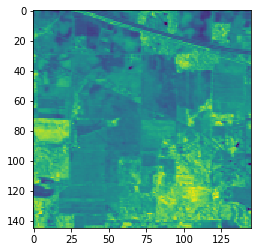

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(data_array[:,:,42], interpolation='nearest')
plt.show()

In [ ]:
data_array_flat = data_array.reshape(-1,200)

Kmeans Clustering

(-0.5, 144.5, 144.5, -0.5)

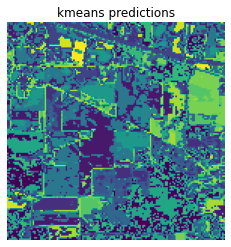

In [ ]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=16, n_init = 500, max_iter=10000)
km.fit(data_array_flat)

# use the sklearn kmeans .predict data_array to assign all the pixels of an image to a unique cluster
predictions_km = km.predict(data_array_flat)

# rehsape the flattened precition array into an MxN prediction mask
prediction_mask_km = predictions_km.reshape((145,145))

#plot the imagery and the prediction mask for comparison
plt.imshow(prediction_mask)
plt.title('kmeans predictions')
plt.axis('off')
# plt.close()

Agglomerative Clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)



> Plot Dendogram for agglomerative clustering



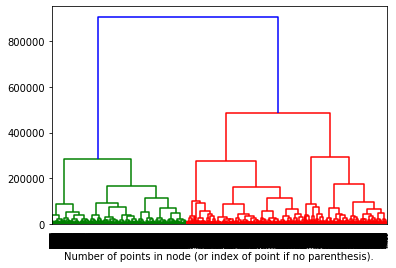

In [ ]:
ac = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
Z = ac.fit(data_array_flat)
plot_dendrogram(Z, truncate_mode="level", p=8)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()


> Get predictions of agglomerative clustering for 16 clusters



(-0.5, 144.5, 144.5, -0.5)

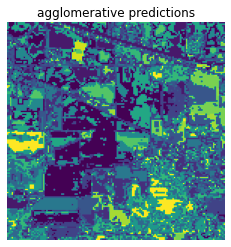

In [ ]:
ac = AgglomerativeClustering(n_clusters=16)
predictions = ac.fit_predict(data_array_flat)

# rehsape the flattened precition array into an MxN prediction mask
prediction_mask = predictions.reshape((145,145))

#plot the imagery and the prediction mask for comparison
plt.imshow(prediction_mask)
plt.title('agglomerative predictions')
plt.axis('off')
# plt.close()

Ground Truth for Indian Pines

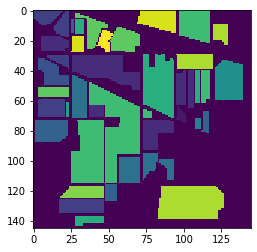

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(gt, interpolation='nearest')
plt.show()

Code to run BHC

In [ ]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from graphviz import Digraph
from scipy.cluster.hierarchy import dendrogram, linkage

from bhc import (BayesianHierarchicalClustering,
                 BayesianRoseTrees,
                 NormalInverseWishart)


def plot_data(data):
    plt.style.use('seaborn-poster')
    plt.figure(facecolor="white", figsize=(6, 4))
    ax = plt.gca()
    ax.set_axisbelow(True)

    ax.grid(True, color='lightgrey', linestyle='-', alpha=0.4)
    ax.tick_params(axis='both', which='both', length=0, labelcolor='0.5')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    for i in range(data.shape[0]):
        if i < 10:
            plt.scatter(data[i, 0], data[i, 1], s=200, color='#1F77B4',
                        marker=r"$ {} $".format(str(i)))
        else:
            plt.scatter(data[i, 0], data[i, 1], s=200, color='#FF7F0E',
                        marker=r"$ {} $".format(str(i)))

    plt.xlabel('x', fontsize=18, weight='light', color='0.35')
    plt.ylabel('y', fontsize=18, weight='light', color='0.35')

    plt.xticks(np.arange(0, 8 + 1, 1), fontsize=14)
    plt.yticks(np.arange(0, 11 + 1, 1), fontsize=14)

    plt.draw()
    plt.savefig('results/data_plot.png', format='png', dpi=100)


def run_linkage(data, method):
    plt.clf()
    Z = linkage(data, method)
    dendrogram(Z, truncate_mode="level", p=4)
    plt.draw()
    plt.savefig(
        'results/linkage_{0}_plot.png'.format(method), format='png', dpi=100)


def run_bhc(data):
    # Hyper-parameters (these values must be optimized!)
    g = 20
    scale_factor = 0.001
    alpha = 1

    model = NormalInverseWishart.create(data, g, scale_factor)

    bhc_result = BayesianHierarchicalClustering(data,
                                                model,
                                                alpha,
                                                cut_allowed=True).build()

    build_graph(bhc_result.node_ids,
                bhc_result.arc_list,
                'results/bhc_plot')


def run_brt(data):
    # Hyper-parameters (these values must be optimized!)
    g = 10
    scale_factor = 0.001
    alpha = 0.5

    model = NormalInverseWishart.create(data, g, scale_factor)

    brt_result = BayesianRoseTrees(data,
                                   model,
                                   alpha,
                                   cut_allowed=True).build()

    build_graph(brt_result.node_ids,
                brt_result.arc_list,
                'results/brt_plot')


def build_graph(node_ids, arc_list, filename):
    dag = Digraph()

    for id in node_ids:
        dag.node(str(id))

    for arc in arc_list:
        dag.edge(str(arc.source), str(arc.target))

    dag.render(filename=filename, format='png', cleanup=True)

data = data_array_flat
ground_truth = scipy.io.loadmat('/content/Indian_pines_gt.mat')
run_bhc(data)